# 七、 GCN-边预测
- encode：将节点映射到低维空间，保留结构和特征信息。
- decode：基于节点嵌入计算节点对的连接概率。

/home/sunqi/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
GCNLinkPrediction(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
)
Epoch: 010, Loss: 0.6122, Val: 0.6442, Test: 0.6540
Epoch: 020, Loss: 0.5288, Val: 0.7514, Test: 0.7550
Epoch: 030, Loss: 0.5019, Val: 0.7789, Test: 0.7621
Epoch: 040, Loss: 0.4803, Val: 0.7666, Test: 0.7668
Epoch: 050, Loss: 0.4664, Val: 0.7647, Test: 0.7687
Epoch: 060, Loss: 0.4571, Val: 0.7723, Test: 0.7649
Epoch: 070, Loss: 0.4468, Val: 0.7903, Test: 0.7915
Epoch: 080, Loss: 0.4454, Val: 0.7808, Test: 0.7725
Epoch: 090, Loss: 0.4437, Val: 0.7685, Test: 0.7825
Epoch: 100, Loss: 0.4392, Val: 0.7837, Test: 0.7659
Epoch: 110, Loss: 0.4446, Val: 0.7657, Test: 0.7801
Epoch: 120, Loss: 0.4423, Val: 0.7780, Test: 0.7630
Epoch: 130, Loss: 0.4419, Val: 0.7694, Test: 0.7754
Epoch: 140, Loss: 0.4405, Val: 0.7704, Test: 0.7773
Epoch: 150, Loss: 0.4394, Val: 0.7770, Test: 0.7848
Epoch: 160, Loss: 0.4326, Val: 0.7723, Test: 0.7749
Epoch: 170, Loss: 0.4

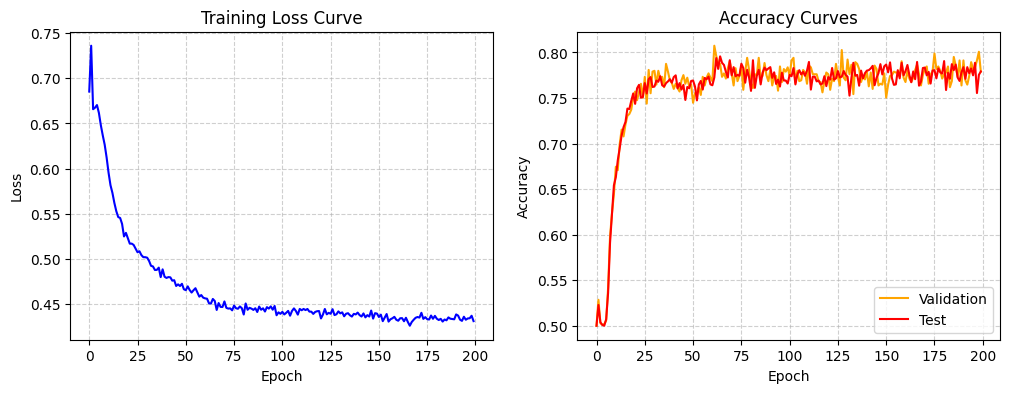

=== Final Results ===
Best Validation Accuracy: 0.8074
Final Validation Accuracy: 0.7827
Final Test Accuracy: 0.7720


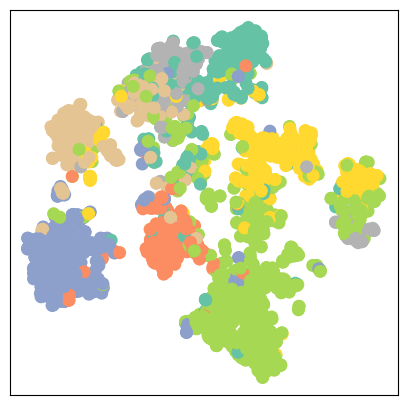

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv  # GCN层
from torch_geometric.datasets import Planetoid  # 加载数据集
from torch_geometric.utils import negative_sampling  # 负采样
import matplotlib.pyplot as plt  # 可视化
from sklearn.manifold import TSNE  # 降维

# 加载Cora数据集
dataset = Planetoid(root='../datasets', name='Cora')
data = dataset[0]

# 检查数据
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {dataset.num_features}")

# GCN边预测模型
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
    
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x
    
    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)
    
    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)

# 初始化模型，隐藏层维度是16
model = GCNLinkPrediction(num_features=dataset.num_features,
                         hidden_channels=16)
print(model)

# 设置优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 划分训练/验证/测试边
edge_index = data.edge_index
num_edges = edge_index.size(1)
num_val = int(num_edges * 0.05)
num_test = int(num_edges * 0.1)

# 随机打乱边
perm = torch.randperm(num_edges)
val_edge_index = edge_index[:, perm[:num_val]]
test_edge_index = edge_index[:, perm[num_val:num_val+num_test]]
train_edge_index = edge_index[:, perm[num_val+num_test:]]

# 训练函数
def train():
    model.train()
    optimizer.zero_grad()
    
    # 负采样
    neg_edge_index = negative_sampling(
        edge_index=train_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=train_edge_index.size(1))
    
    # 合并正负样本
    edge_label_index = torch.cat(
        [train_edge_index, neg_edge_index],
        dim=1)
    edge_label = torch.cat([
        torch.ones(train_edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ], dim=0).to(data.x.device)
    
    # 前向传播
    out = model(data.x, train_edge_index, edge_label_index).view(-1)
    loss = F.binary_cross_entropy_with_logits(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

# 测试函数
@torch.no_grad()
def test(edge_index, neg_edge_index):
    model.eval()
    
    # 合并正负样本
    edge_label_index = torch.cat([edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat([
        torch.ones(edge_index.size(1)),
        torch.zeros(neg_edge_index.size(1))
    ], dim=0).to(data.x.device)
    
    # 前向传播
    out = model(data.x, train_edge_index, edge_label_index).view(-1)
    pred = (torch.sigmoid(out) > 0.5).float()
    acc = pred.eq(edge_label).float().mean().item()
    return acc

# 训练过程记录
train_losses = []
val_accs = []
test_accs = []
best_val_acc = 0
best_model_state = None

# 迭代训练
for epoch in range(1, 201):
    loss = train()
    
    # 验证集和测试集的负采样
    val_neg_edge_index = negative_sampling(
        edge_index=val_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=val_edge_index.size(1))
    
    test_neg_edge_index = negative_sampling(
        edge_index=test_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=test_edge_index.size(1))
    
    # 计算准确率
    val_acc = test(val_edge_index, val_neg_edge_index)
    test_acc = test(test_edge_index, test_neg_edge_index)
    
    # 记录指标
    train_losses.append(loss)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), 'output/07-gcn-link.pth')
    
    # 打印训练信息
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# 降维并可视化
def visualize(h, color, epoch=None, save=False):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    if save:
        plt.savefig(f'output/embedding_{epoch}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 训练曲线可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation', color='orange')
plt.plot(test_accs, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 最终评估
model.load_state_dict(best_model_state)
val_neg_edge_index = negative_sampling(
    edge_index=val_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=val_edge_index.size(1))
test_neg_edge_index = negative_sampling(
    edge_index=test_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=test_edge_index.size(1))

final_val = test(val_edge_index, val_neg_edge_index)
final_test = test(test_edge_index, test_neg_edge_index)

print('=== Final Results ===')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Final Validation Accuracy: {final_val:.4f}')
print(f'Final Test Accuracy: {final_test:.4f}')

# 节点嵌入可视化
model.eval()
z = model.encode(data.x, data.edge_index)
visualize(z, color=data.y)